#### Main Audition Notebook

In [1]:
import os
import sys
import json
import itertools
import yaml
import pandas as pd
from sqlalchemy.engine.url import URL

In [2]:
from src.utils.general import get_db_conn, get_boto3_session
from src.utils import project_constants as constants

In [3]:
from triage.component.audition import Auditioner
from triage.component.audition.pre_audition import PreAudition
from triage import create_engine

In [4]:
cred_file = '../conf/local/credentials.yaml'

#### db connection 

In [5]:
with open(cred_file) as f:
    db_config = yaml.load(f)['db']

db_url = URL(
    'postgres',
    host=db_config['host'],
    username=db_config['user'],
    database=db_config['db'],
    password=db_config['pass'],
    port=db_config['port'],
)

db_con = create_engine(db_url)

/home/kasun/.pyenv/versions/aclu/lib/python3.7/site-packages/ipykernel_launcher.py:2: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  


In [6]:
# experiment_hash = 'dc52ec9e21af7cceb2abd22e876040dd'
# experiment_hash = '170870efbfa049eff695a0423dfe5ea8' # The last passage experiment with the percentile rankers
experiment_hash = '5bf28511f823b995bb5f843574ba2282' # Experiment with 1mo model freq, and fixed bill age

### Preaudition

In [7]:
# pre_aud = PreAudition(db_con)

# model_groups = pre_aud.get_model_groups_from_experiment(experiment_hash)
# end_times = pre_aud.get_train_end_times(after='2011-01-01')

In [8]:
# model_groups

In [9]:
# len(end_times)

In [10]:
# print(model_groups)

#### Model groups

In [11]:
q = """
    select distinct(model_group_id) from triage_metadata.models where built_by_experiment='{exp_hash}'
""".format(
    exp_hash=experiment_hash
)
df = pd.read_sql(q, db_con)
model_groups = df['model_group_id'].tolist()

#### Train end times

In [12]:
q = """
    select distinct(train_end_time) from triage_metadata.models where built_by_experiment='{exp_hash}' order by train_end_time
""".format(
    exp_hash=experiment_hash
)
df = pd.read_sql(q, db_con)
train_end_times =  df['train_end_time'].tolist()

In [13]:
len(train_end_times)

36

#### Initial Metric filters

In [14]:
metric_filters = [
    {
    'metric': 'precision@',
    'parameter': '10_pct',
    'max_from_best': 1,
    'threshold_value': 0.0
    },
    {
    'metric': 'precision@',
    'parameter': '20_pct',
    'max_from_best': 1,
    'threshold_value': 0.0
    },
    {
    'metric': 'precision@',
    'parameter': '30_pct',
    'max_from_best': 1,
    'threshold_value': 0.0
    }
]

# metric_filters = [{
#     'metric': 'precision@',
#     'parameter': param,
#     'max_from_best': 0.4,
#     'threshold_value': 0.3
# }]

In [15]:
aud = Auditioner(
    db_engine=db_con,
    model_group_ids=model_groups,
    train_end_times=train_end_times,
    initial_metric_filters=metric_filters,
    models_table='models',
    distance_table='best_dist_long_term'
)

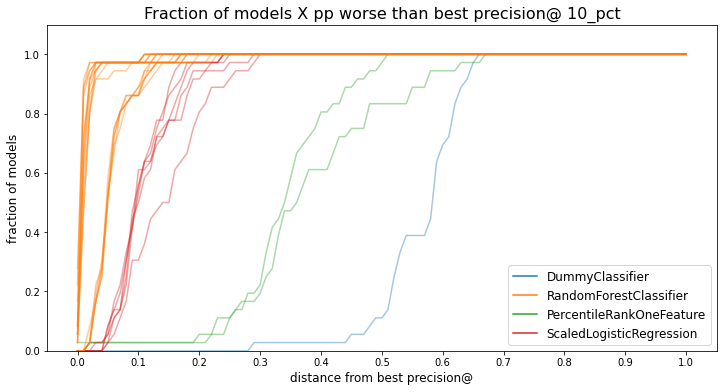

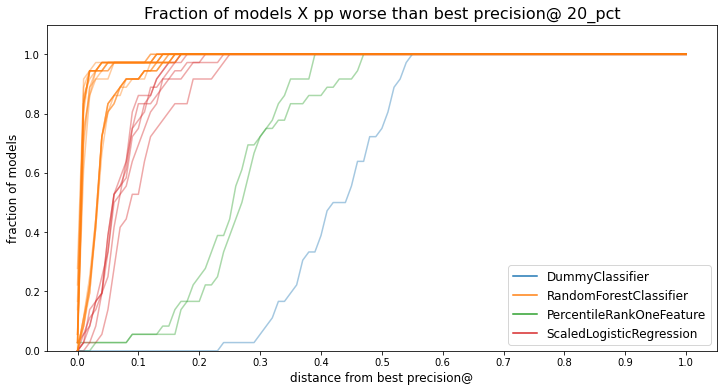

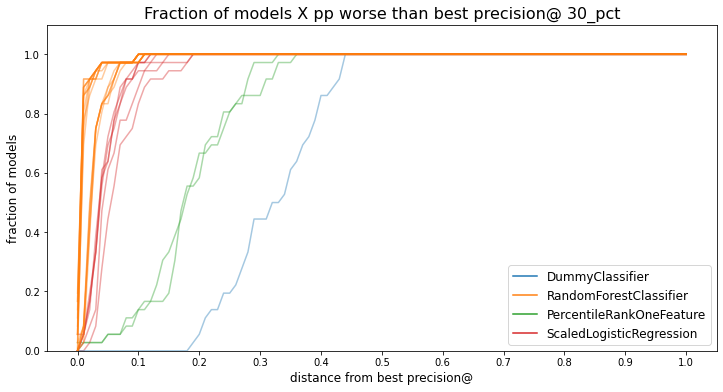

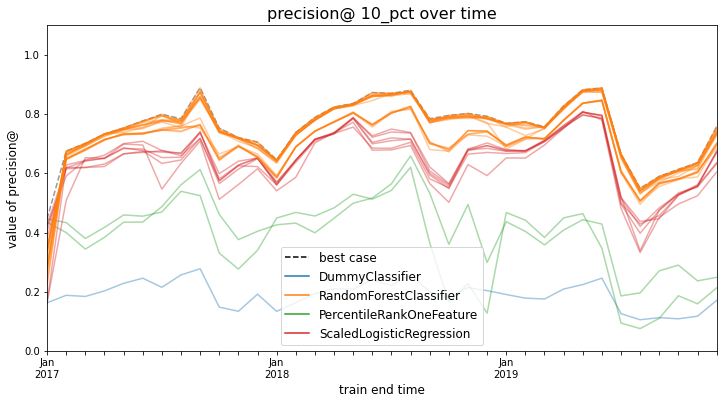

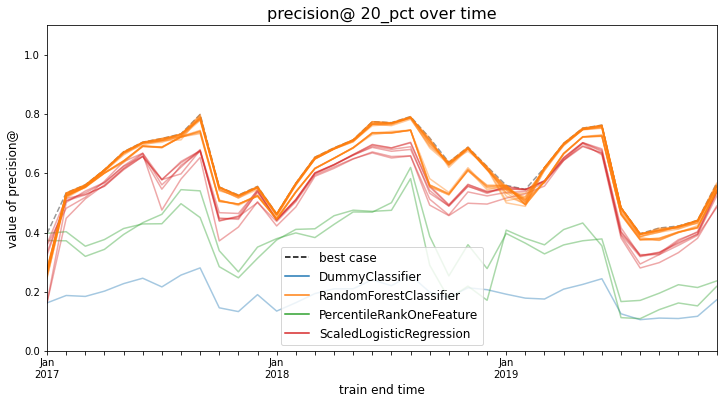

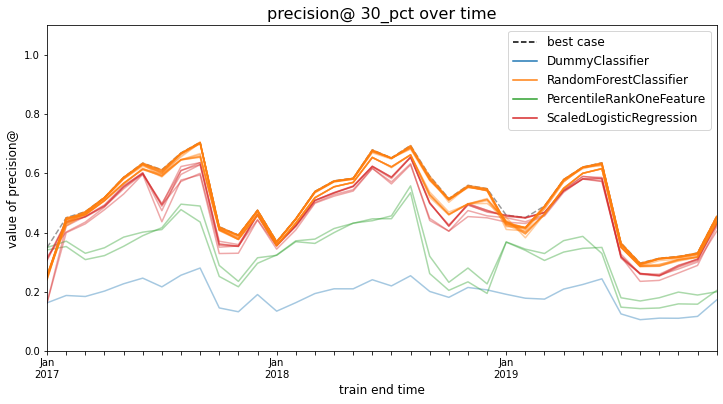

In [16]:
%matplotlib inline
aud.plot_model_groups()

In [17]:
ids = aud.thresholded_model_group_ids

In [18]:
# ids

In [19]:
len(ids)

27

#### Tightening thresholds

In [20]:
metric_filters = [
    {
    'metric': 'precision@',
    'parameter': '10_pct',
    'max_from_best': 0.05,
    'threshold_value': 0
    },
    {
    'metric': 'precision@',
    'parameter': '20_pct',
    'max_from_best': 0.1,
    'threshold_value': 0
    },
    {
    'metric': 'precision@',
    'parameter': '30_pct',
    'max_from_best': 0.1,
    'threshold_value': 0
    }
]

In [21]:
aud = Auditioner(
    db_engine=db_con,
    model_group_ids=model_groups,
    train_end_times=train_end_times,
    initial_metric_filters=metric_filters,
    models_table='models',
    distance_table='best_dist_long_term'
)

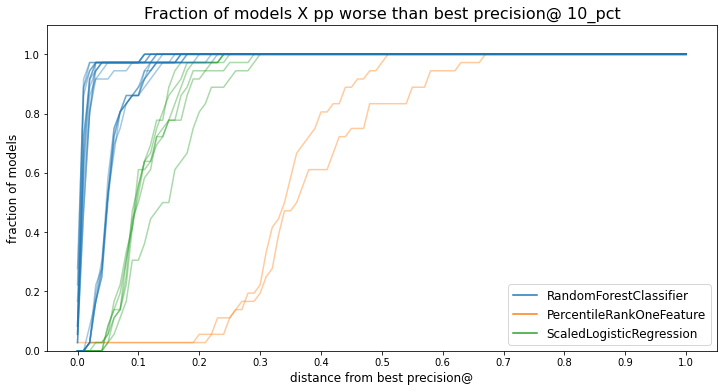

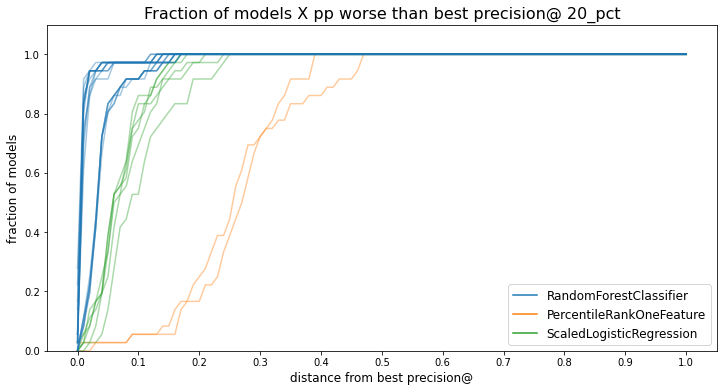

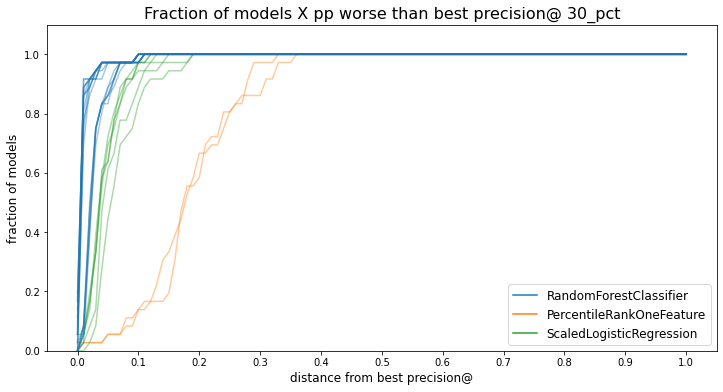

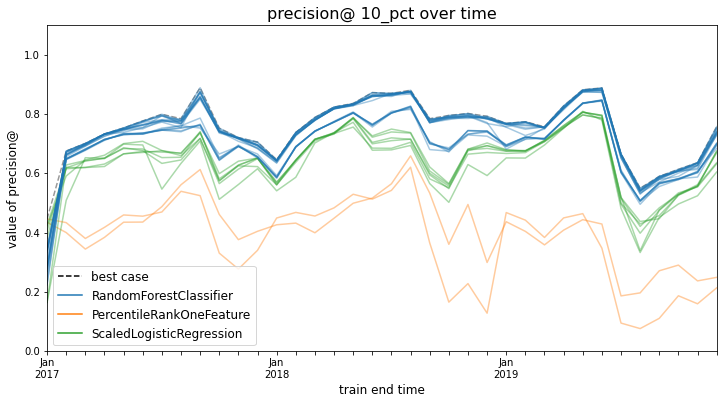

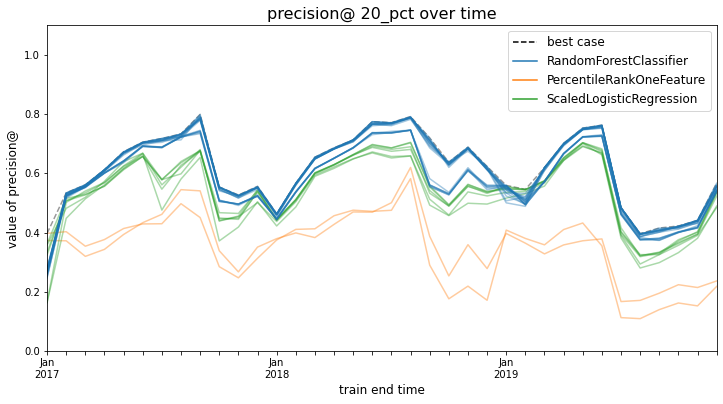

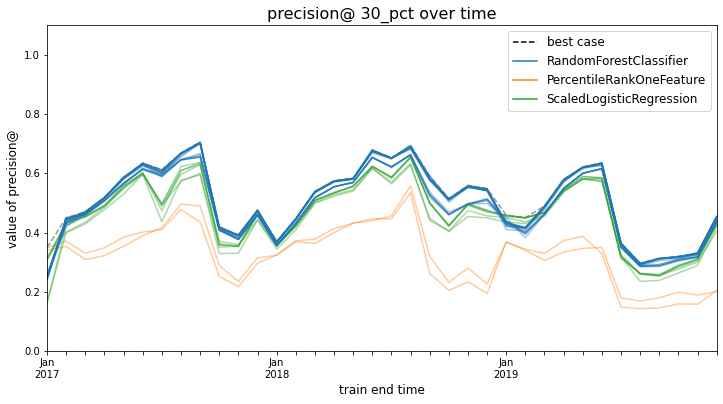

In [22]:
%matplotlib inline
aud.plot_model_groups()

In [23]:
ids = aud.thresholded_model_group_ids
len(ids)

26

#### Rules Maker

In [24]:
from triage.component.audition.rules_maker import (
    SimpleRuleMaker, RandomGroupRuleMaker, create_selection_grid
)

In [25]:
rule1 =  SimpleRuleMaker()
rule1.add_rule_best_current_value(metric='precision@', parameter='10_pct', n=3)
rule1.add_rule_best_average_value(metric='precision@', parameter='10_pct', n=3)
rule1.add_rule_lowest_metric_variance(metric='precision@', parameter='10_pct', n=3)
rule1.add_rule_most_frequent_best_dist(metric='precision@', parameter='10_pct', n=3)
# rule1.add_rule_best_avg_var_penalized(metric='precision@', parameter=param, n=3)
rule1.add_rule_best_avg_recency_weight(metric='precision@', parameter='10_pct', n=3, decay_type='exponential')


rule2 = RandomGroupRuleMaker(n=1)

rules = create_selection_grid(rule1, rule2)

/home/kasun/.pyenv/versions/aclu/lib/python3.7/site-packages/triage/component/audition/selection_rules.py:203: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  "int"


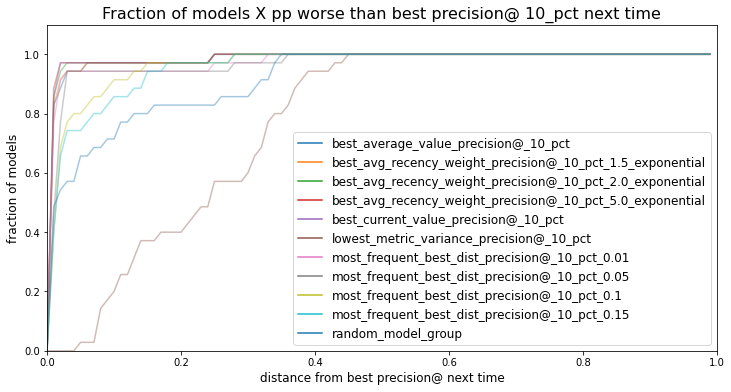

/home/kasun/.pyenv/versions/aclu/lib/python3.7/site-packages/triage/component/audition/selection_rules.py:203: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  "int"


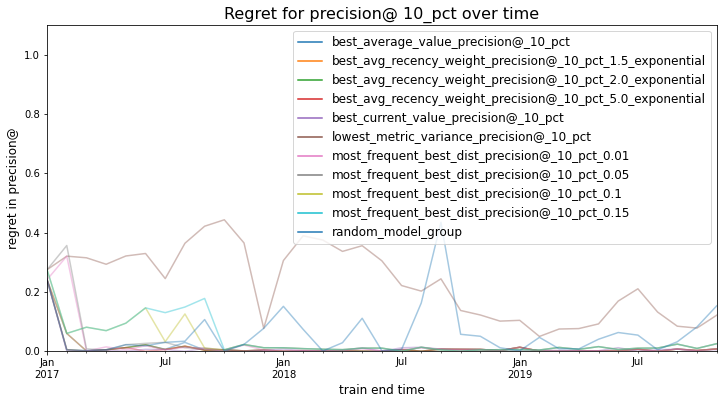

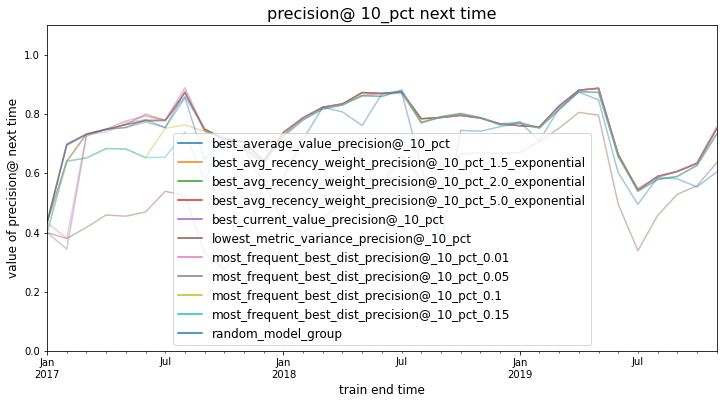

/home/kasun/.pyenv/versions/aclu/lib/python3.7/site-packages/triage/component/audition/selection_rules.py:203: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  "int"


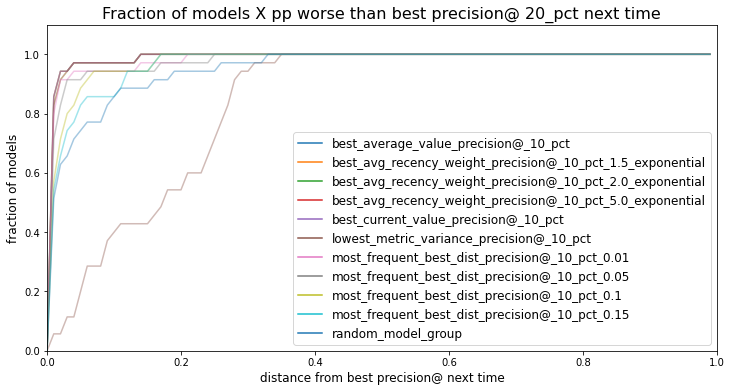

/home/kasun/.pyenv/versions/aclu/lib/python3.7/site-packages/triage/component/audition/selection_rules.py:203: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  "int"


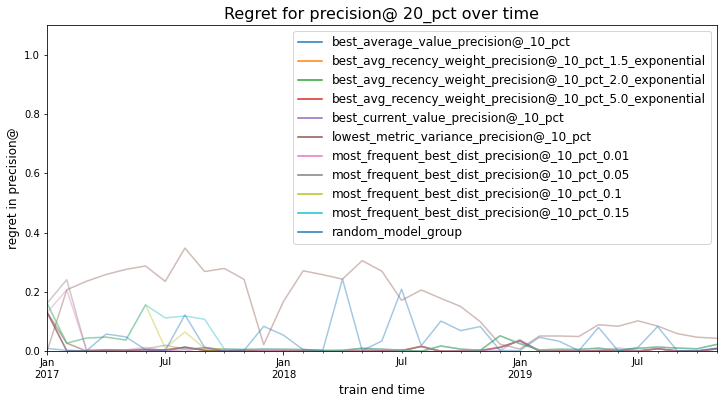

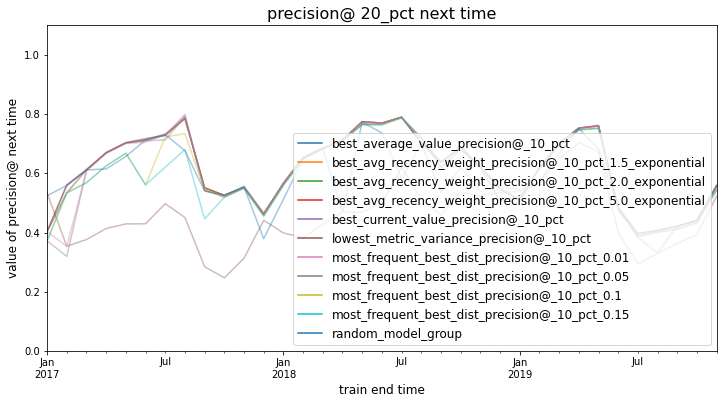

/home/kasun/.pyenv/versions/aclu/lib/python3.7/site-packages/triage/component/audition/selection_rules.py:203: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  "int"


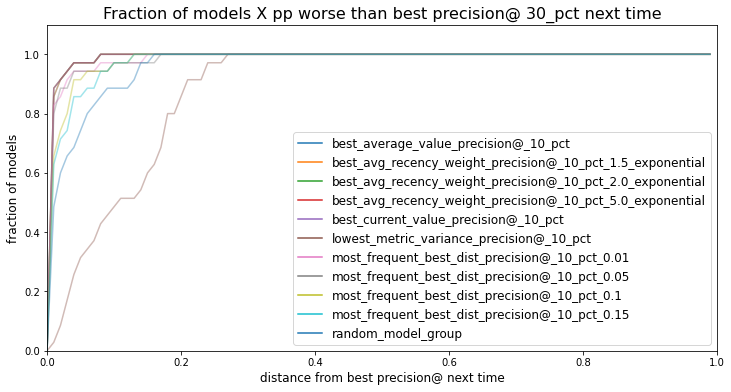

/home/kasun/.pyenv/versions/aclu/lib/python3.7/site-packages/triage/component/audition/selection_rules.py:203: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  "int"


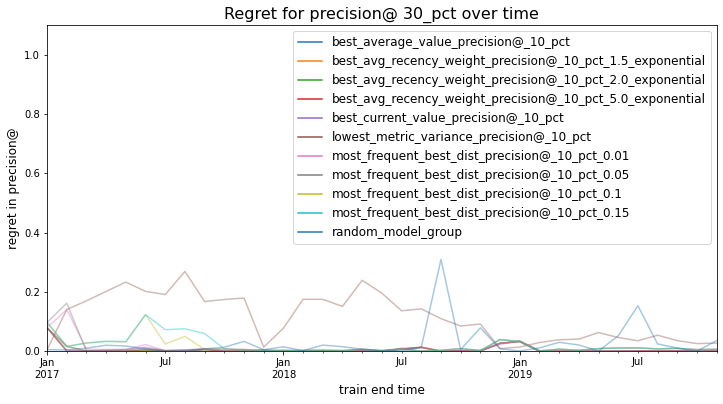

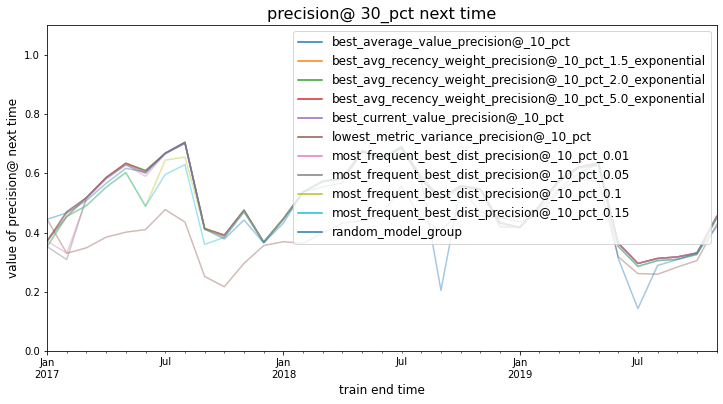

In [26]:
aud.register_selection_rule_grid(rules, plot=True)

In [27]:
# aud.results_for_rule['precision@10_pct'].sort_values(
#     ['regret', 'raw_value_next_time'], ascending=[True, False]).head()

In [28]:
aud.selection_rule_model_group_ids

/home/kasun/.pyenv/versions/aclu/lib/python3.7/site-packages/triage/component/audition/selection_rules.py:203: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  "int"


{'best_current_value_precision@_10_pct': [747, 752, 751],
 'best_average_value_precision@_10_pct': [751, 752, 748],
 'lowest_metric_variance_precision@_10_pct': [731, 737, 749],
 'most_frequent_best_dist_precision@_10_pct_0.01': [751, 747, 752],
 'most_frequent_best_dist_precision@_10_pct_0.05': [738, 740, 741],
 'most_frequent_best_dist_precision@_10_pct_0.1': [738, 740, 741],
 'most_frequent_best_dist_precision@_10_pct_0.15': [738, 741, 743],
 'best_avg_recency_weight_precision@_10_pct_1.5_exponential': [751, 752, 748],
 'best_avg_recency_weight_precision@_10_pct_2.0_exponential': [751, 752, 748],
 'best_avg_recency_weight_precision@_10_pct_5.0_exponential': [752, 751, 747],
 'random_model_group': [735]}

In [49]:
# dir(aud)

#### Model collections for the rules

In [50]:
# aud.results_for_rule['precision@10_pct'].groupby(['selection_rule']).count()

In [29]:
grp = aud.results_for_rule['precision@10_pct'].groupby(['selection_rule'])

model_collections = dict()
for rule, df in grp:
    t = df[['train_end_time', 'model_group_id']].to_dict('records')
    model_collections[rule] = [{str(x['train_end_time']): x['model_group_id']} for x in t]

In [30]:
model_collections

{'best_average_value_precision@_10_pct': [{'2017-01-01 00:00:00': 733},
  {'2017-02-01 00:00:00': 731},
  {'2017-03-01 00:00:00': 750},
  {'2017-04-01 00:00:00': 750},
  {'2017-05-01 00:00:00': 755},
  {'2017-06-01 00:00:00': 755},
  {'2017-07-01 00:00:00': 755},
  {'2017-08-01 00:00:00': 755},
  {'2017-09-01 00:00:00': 751},
  {'2017-10-01 00:00:00': 751},
  {'2017-11-01 00:00:00': 751},
  {'2017-12-01 00:00:00': 751},
  {'2018-01-01 00:00:00': 751},
  {'2018-02-01 00:00:00': 751},
  {'2018-03-01 00:00:00': 751},
  {'2018-04-01 00:00:00': 751},
  {'2018-05-01 00:00:00': 751},
  {'2018-06-01 00:00:00': 751},
  {'2018-07-01 00:00:00': 751},
  {'2018-08-01 00:00:00': 751},
  {'2018-09-01 00:00:00': 751},
  {'2018-10-01 00:00:00': 751},
  {'2018-11-01 00:00:00': 751},
  {'2018-12-01 00:00:00': 751},
  {'2019-01-01 00:00:00': 751},
  {'2019-02-01 00:00:00': 751},
  {'2019-03-01 00:00:00': 751},
  {'2019-04-01 00:00:00': 751},
  {'2019-05-01 00:00:00': 751},
  {'2019-06-01 00:00:00': 751},


#### Rule similaity

In [118]:
unique_model_groups = dict()
for rule in model_collections:
    models = [ [y for y in x.values()][0] for x in model_collections[rule]]
    
    unique_model_groups[rule] = set(models)

In [121]:
def jaccard_similarity(set1, set2):
    inter_size = len(set1.intersection(set2))
    union_size = len(set1.union(set2))
    
    return float(inter_size)/union_size

In [127]:
prod = itertools.combinations(unique_model_groups.keys(), 2)

similarities = list()
for x, y in prod:
    d = dict()
    d['rule1'] = x
    d['rule2'] = y
    d['jaccard'] = jaccard_similarity(unique_model_groups[x], unique_model_groups[y])
    
    similarities.append(d)

In [130]:
pd.DataFrame(similarities).sort_values('jaccard', ascending=False)

,rule1,rule2,jaccard
9,best_avg_recency_weight_precision@_10_pct_1.5_...,best_avg_recency_weight_precision@_10_pct_2.0_...,0.857143
17,best_avg_recency_weight_precision@_10_pct_2.0_...,best_avg_recency_weight_precision@_10_pct_5.0_...,0.750000
0,best_average_value_precision@_10_pct,best_avg_recency_weight_precision@_10_pct_1.5_...,0.666667
10,best_avg_recency_weight_precision@_10_pct_1.5_...,best_avg_recency_weight_precision@_10_pct_5.0_...,0.625000
1,best_average_value_precision@_10_pct,best_avg_recency_weight_precision@_10_pct_2.0_...,0.571429
2,best_average_value_precision@_10_pct,best_avg_recency_weight_precision@_10_pct_5.0_...,0.375000
24,best_avg_recency_weight_precision@_10_pct_5.0_...,best_current_value_precision@_10_pct,0.315789
18,best_avg_recency_weight_precision@_10_pct_2.0_...,best_current_value_precision@_10_pct,0.250000
12,best_avg_recency_weight_precision@_10_pct_1.5_...,most_frequent_best_dist_precision@_10_pct_0.01,0.222222
11,best_avg_recency_weight_precision@_10_pct_1.5_...,best_current_value_precision@_10_pct,0.200000


#### Inspecting model groups that jump out

In [31]:
q = """select 
        model_group_id,
        hyperparameters
    from triage_metadata.model_groups 
    where model_group_id in 
    (751, 733, 731, 750, 738)
    --(712, 716, 654, 694, 703, 676, 671, 680, 687, 588, 634)
"""

t = pd.read_sql(q, db_con)
t['hyperparameters'] = t['hyperparameters'].astype(str)
t.to_dict('records')

[{'model_group_id': 731, 'hyperparameters': "{'C': 0.01, 'penalty': 'l2'}"},
 {'model_group_id': 733,
  'hyperparameters': "{'descend': False, 'feature': 'sp_success_entity_id_all_success_rate_max'}"},
 {'model_group_id': 738,
  'hyperparameters': "{'criterion': 'gini', 'max_depth': 25, 'class_weight': None, 'max_features': 'sqrt', 'n_estimators': 100, 'min_samples_split': 50}"},
 {'model_group_id': 750,
  'hyperparameters': "{'criterion': 'gini', 'max_depth': 25, 'class_weight': None, 'max_features': 'sqrt', 'n_estimators': 2000, 'min_samples_split': 50}"},
 {'model_group_id': 751,
  'hyperparameters': "{'criterion': 'gini', 'max_depth': 50, 'class_weight': None, 'max_features': 'sqrt', 'n_estimators': 2000, 'min_samples_split': 10}"}]

In [ ]:
t['hyperparameters'].tolist()

#### Save Predictions of the model groups we are interested in

In [33]:
from src.bill_passage.postmodeling.save_predictions import generate_predictions

In [ ]:
model_groups = [751, 733, 731]
project_folder = 's3://aclu-leg-tracker/experiment_data/bill_passage/triage/national_lt'

generate_predictions(
    db_engine=db_con,
    model_groups=model_groups,
    project_path=project_folder,
    replace=True
)

2021-09-22 16:13:06 -    INFO Found 108 model ids
2021-09-22 16:13:06 -    INFO Each model group contains 36 models
2021-09-22 16:13:06 -    INFO Instantiating storage engines and the predictor
2021-09-22 16:13:06 -    INFO Processing 3 model_ids for train matrix 0319e75cd0e62bb9113e67d33a519802 and test matrix 8ae7150d817be2dda465fcca608536e9
2021-09-22 16:13:24 -    INFO Writing predictions for model_id 17075
2021-09-22 16:13:25 -  NOTICE You got feature values that are out of the range: (0, 1). The feature values will cutoff to fit in the range (0, 1).
2021-09-22 16:13:27 -    INFO Writing predictions for model_id 17077
2021-09-22 16:13:30 -    INFO Writing predictions for model_id 17618
2021-09-22 16:18:55 -    INFO Processing 3 model_ids for train matrix 04a7c87c04fef75a41b08d9c94ce231f and test matrix 3ea41830ea5bb8277651c8c852ea8e44
2021-09-22 16:19:03 -    INFO Writing predictions for model_id 16948
2021-09-22 16:19:05 -  NOTICE You got feature values that are out of the range: